In [1]:
from google.colab import drive
drive.mount('/content/drive')

from tensorflow.python.keras.backend import clear_session
import tensorflow as tf,keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pylab as plt
import torch.utils.data as data
#import h5py
#import csv
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
import torch
import keras
from tensorflow.keras.models import Sequential
from keras.layers import Input, Dense, LSTM,Dropout
from tensorflow.keras.utils import to_categorical
from keras.models import Model
from torchvision import transforms

Mounted at /content/drive


# class EEGloader
loadData


In [2]:
class eegloader(data.Dataset):
	def __init__(self, data_path, labels, data_dir='./', dlen=160, stpt=320, nch=128):

		data = torch.load(data_dir + data_path)
		self.mean = data['means']
		self.stdev = data['stddevs']
		self.labels = labels
		self.data = []
    
		for l in self.labels:
			self.data.append(data['dataset'][l])

		assert len(self.data)==len(self.labels)
		self.dlen = dlen
		self.stpt = stpt
		self.nch = nch

	def __len__(self):
		return len(self.data)
	
	def __getitem__(self, idx):
		nch  = self.nch
		dlen = self.dlen 
		stpt = self.stpt
	
		x = np.zeros((nch,dlen))
		y = self.data[idx]['label']
		s = self.data[idx]['subject'] 
		
		x = torch.from_numpy(x)
		x[:,:min(int(self.data[idx]['eeg'].shape[1]),dlen)] = self.data[idx]['eeg'][:,stpt:stpt+dlen]
		x = x.type(torch.FloatTensor).sub(self.mean.expand(nch,dlen))/ self.stdev.expand(nch,dlen)

		return x,y,s

def load_data(data_path, labels, path ,dlen , stpt):
  


    x = eegloader(data_path, labels, path ,dlen, stpt)
    eeg = []
    y_labels = []
    x_train=[]
    y_train=[]
    x_test=[]
    y_test=[]
    x_val =[]
    y_val =[]
    train_size = int(len(x)*0.8)
    val_size = int(len(x)*0.1)
    test_size = len(x) - train_size - val_size

    for i in range(len(x)):
        eeg.append(tf.make_ndarray(tf.make_tensor_proto(x[i][0])))
        y_labels.append(x[i][1])

    eeg = np.transpose(np.array(eeg),(0,2,1))
    y_labels = np.array(y_labels)


    x_train = np.array(eeg[0:train_size])
    y_train = np.array(y_labels[0:train_size])
    x_test = np.array(eeg[train_size:train_size+test_size])
    y_test = np.array(y_labels[train_size:train_size+test_size])
    x_val = np.array(eeg[train_size+test_size:len(x)])
    y_val = np.array(y_labels[train_size+test_size:len(x)]) 
                      
    del(x,eeg,y_labels)
    return (x_train,y_train,x_test,y_test,x_val,y_val)

In [3]:
path = '/content/drive/My Drive/Dataset/eeg/'
data_path = 'eeg_signals_128_sequential_band_all_with_mean_std.pth'
diff = 200       ## diff
strt = 50   ## star of time point


data1 = torch.load(path + data_path)
dst = data1['dataset']
labels = []
labels2 = []
for i in range(len(dst)):
  labels.append(dst[i]['image'])

labels = np.argsort(labels) 

x_train,y_train,x_test,y_test,x_val,y_val = load_data(data_path, labels, path ,dlen=diff, stpt=strt)

In [4]:
y_train = to_categorical(y_train, num_classes=40)
y_val = to_categorical(y_val, num_classes=40)
y_test = to_categorical(y_test, num_classes=40)

#Transformer


In [25]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        
    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)        
        return self.layernorm2(out1 + ffn_output)


class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if(logs.get('val_accuracy') >= 0.995):
			print("\nReached %2.2f%% accuracy, so stopping training!!" %(100))
			self.model.stop_training = True

In [24]:
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

sequence_input = tf.keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2]))
transformer_block = TransformerBlock(x_train.shape[2], num_heads, ff_dim)
x = transformer_block(sequence_input)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(40, activation="softmax")(x)
model = tf.keras.Model(inputs=sequence_input, outputs=outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 200, 128)]        0         
_________________________________________________________________
transformer_block_3 (Transfo (None, 200, 128)          140832    
_________________________________________________________________
global_average_pooling1d_3 ( (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_15 (Dense)             (None, 40)                5160      
Total params: 162,504
Trainable params: 162,504
Non-trainable params: 0
_________________________________________________________________


In [26]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test),
                   epochs=45, batch_size=32,callbacks = myCallback())
print(model.evaluate(x_test, y_test))

Epoch 1/45
300/300 [==============================] - 9s 26ms/step - loss: 2.0842 - accuracy: 0.4114 - val_loss: 0.9744 - val_accuracy: 0.6976
Epoch 2/45
300/300 [==============================] - 7s 25ms/step - loss: 0.6789 - accuracy: 0.7980 - val_loss: 0.5697 - val_accuracy: 0.8162
Epoch 3/45
300/300 [==============================] - 7s 25ms/step - loss: 0.3519 - accuracy: 0.8973 - val_loss: 0.2960 - val_accuracy: 0.9156
Epoch 4/45
300/300 [==============================] - 7s 24ms/step - loss: 0.2341 - accuracy: 0.9319 - val_loss: 0.2598 - val_accuracy: 0.9206
Epoch 5/45
300/300 [==============================] - 7s 24ms/step - loss: 0.1790 - accuracy: 0.9464 - val_loss: 0.1993 - val_accuracy: 0.9449
Epoch 6/45
300/300 [==============================] - 7s 25ms/step - loss: 0.1237 - accuracy: 0.9644 - val_loss: 0.1393 - val_accuracy: 0.9616
Epoch 7/45
300/300 [==============================] - 7s 25ms/step - loss: 0.1276 - accuracy: 0.9608 - val_loss: 0.1889 - val_accuracy: 0.9382

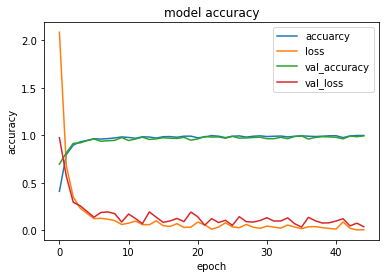

In [27]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuarcy', 'loss','val_accuracy','val_loss'], loc='upper right')
plt.show()

#GAN


In [ ]:
extract = Model(model.inputs, model.layers[-2].output)
features = extract.predict(x_train)
extract.summary()

Model: "model_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200, 128)]        0         
_________________________________________________________________
transformer_block_1 (Transfo (None, 200, 128)          140832    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
Total params: 157,344
Trainable params: 157,344
Non-trainable params: 0
_________________________________________________________________
(9572, 128)
[ 0.          0.8998062   8.458572    5.463703    0.          0.
  0.          6.004793    0.          0.          0.          0.
  0.          0.          0.          1.2443831   0.          0.
  0.          6.841965    0.          1.194